# TextStatisticsPlayground
This notebook is my playground for exploring Foveated Rendering (FR) methods that are amenable to text rendering. In this, we explore examples of how traditional foveated rendering (ie, as described in Guenter 2012 or Patney 2016) look compared to increasingly more complicated methods. The end goal is to come up with a statistically inspired approach to constructing image metamers that will enable text foveation without severely impacting the user experience in reading text.

In [ ]:
%run src/foveation_utils.py
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
keehar_plaintext_rgb  = cv2.imread("input/text/images/keehar-plaintext.png", cv2.IMREAD_COLOR)
keehar_plaintext_grayscale = cv2.cvtColor(keehar_plaintext_rgb, cv2.COLOR_BGR2GRAY)
keehar_plaintext_lab = cv2.cvtColor(keehar_plaintext_rgb, cv2.COLOR_BGR2LAB)
keehar_plaintext_rgb_channels = cv2.split(keehar_plaintext_rgb)
keehar_plaintext_lab_channels = cv2.split(keehar_plaintext_lab)

rgb_colours = ('b', 'g', 'r')

The next cell shows what traditional foveation can do to text; of course, real foveated rendering will do some post-process filtering that will improve the overall look, but for now, this is fine.

In [ ]:
center = (keehar_plaintext_rgb.shape[0] // 2, keehar_plaintext_rgb.shape[1] // 2)
radii = (100, 200)
foveated_keehar_plaintext_rgb = guenter_foveated_rendering_px(keehar_plaintext_rgb, center, radii)
visualize_guenter_foveated_regions_px(foveated_keehar_plaintext_rgb, center, radii)

In [ ]:
# This is just doing the same thing but with a slightly different code implementation. This one is easier to convert to C.
foveated_keehar_plaintext_rgb = guenter_foveated_rendering_px_mip(keehar_plaintext_rgb, center, radii)

visualize_guenter_foveated_regions_px(foveated_keehar_plaintext_rgb, center, radii)

The cell below showcases the different grid regions, although it draws over the fovea unfortunately.

In [ ]:
visualize_foveated_grid_px(foveated_keehar_plaintext_rgb, center, radii, (2, 4))

The first three moments of the image (mean, variance, skew) are computed based on the full resolution image and shown below.

In [ ]:
%run src/foveation_utils.py
(mean_texture_keehar, variance_texture_keehar, skew_texture_keehar) = compute_base_moments(keehar_plaintext_rgb, center, 0.1, base_pooling_size = 8)
visualize_base_moments(mean_texture_keehar, variance_texture_keehar, skew_texture_keehar)

We can also construct the Gaussian and Laplacian Pyramids for a given input image. These are fast to construct; it's computing the base moments that is fairly slow.

It's important to remember, the original paper constructs the Steerable Pyramid, and then compute moments for each level of the pyramid. The cells above and below computed the moments, and construct the pyramids (not Steerable!) from those moments.

In [ ]:
%run src/foveation_utils.py
num_levels = 5
gaussian_pyramids = compute_basemoments_gaussian_pyramids(mean_texture_keehar, variance_texture_keehar, skew_texture_keehar, num_levels)
laplacian_pyramids = compute_basemoments_laplacian_pyramids(gaussian_pyramids)

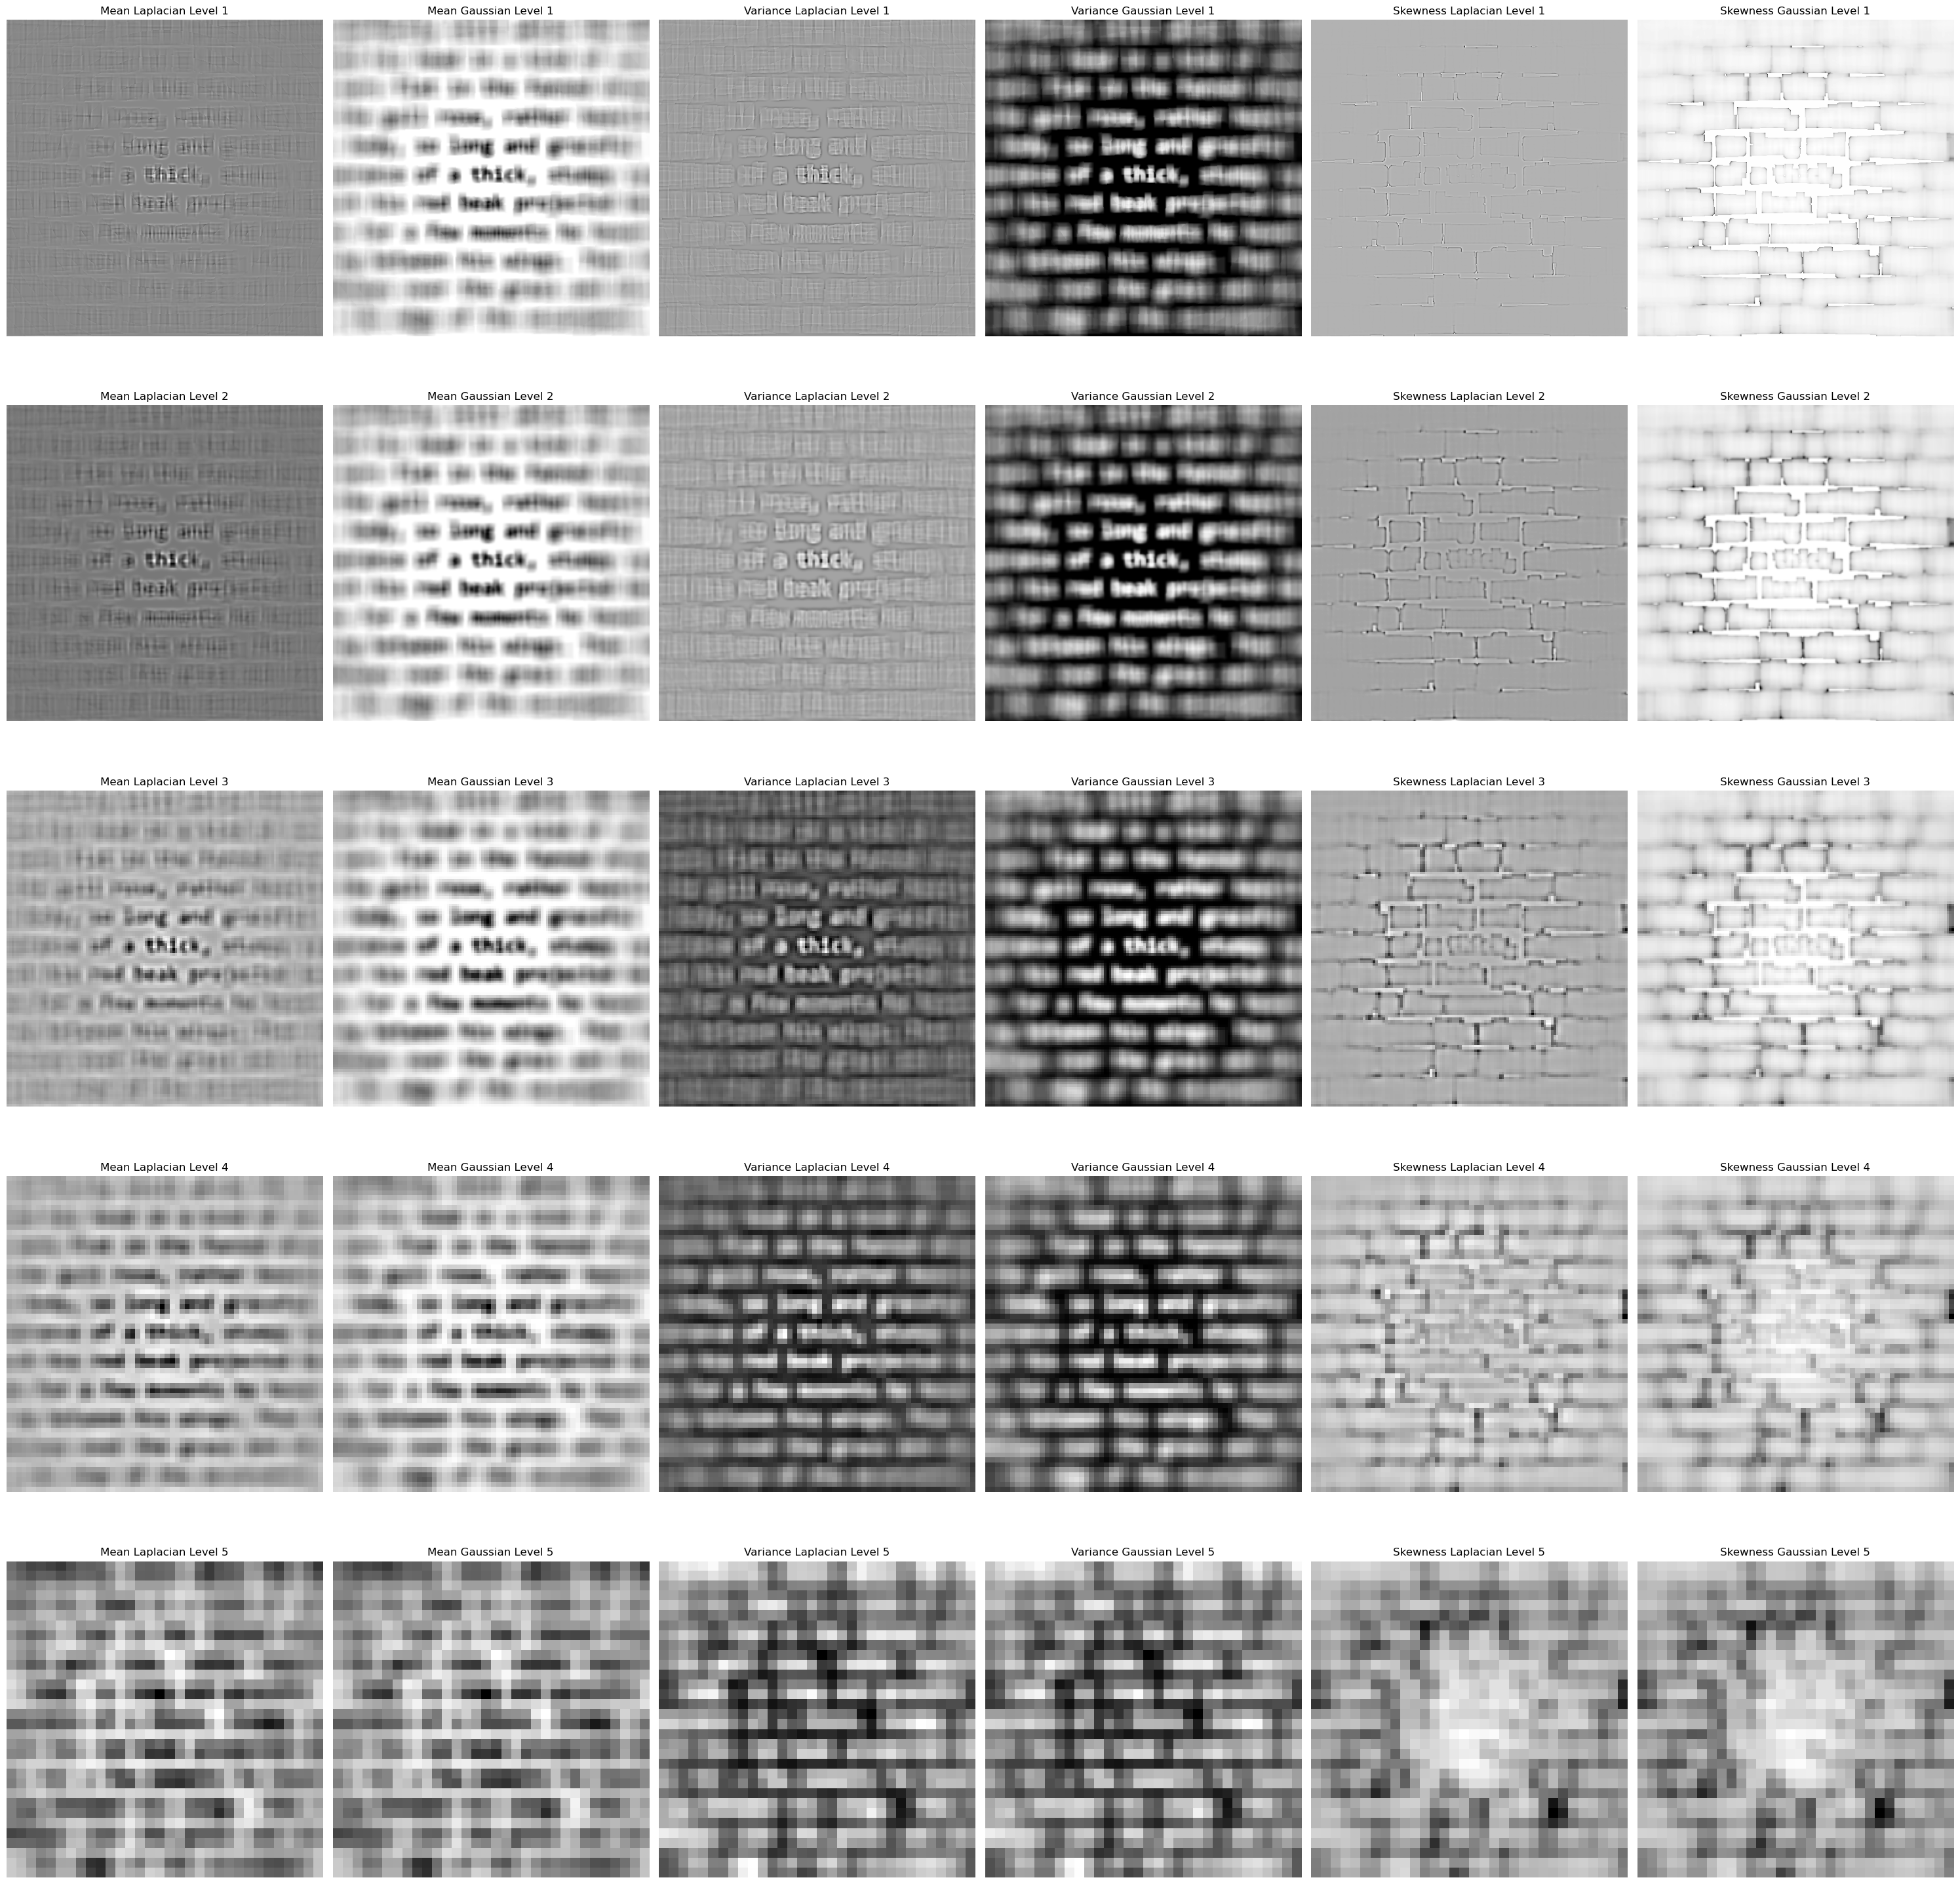

In [20]:
'''
EXTREMELY IMPORTANT FOR INTERPRETATION:

The Laplacian's at level 0 may be very hard to see. 
This is because Laplacians represent the DIFFERENCE in levels, so
the difference between two higher resolution levels is harder to distinguish than 
betweenst lower resolution ones.
'''



fig, axes = plt.subplots(num_levels, 6, figsize=(30, 30))
for i in range(num_levels):
    axes[i, 0].imshow(cv2.normalize(laplacian_pyramids['mean'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 0].set_title(f'Mean Laplacian Level {i+1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(cv2.normalize(gaussian_pyramids['mean'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 1].set_title(f'Mean Gaussian Level {i+1}')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(cv2.normalize(laplacian_pyramids['variance'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 2].set_title(f'Variance Laplacian Level {i+1}')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(cv2.normalize(gaussian_pyramids['variance'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 3].set_title(f'Variance Gaussian Level {i+1}')
    axes[i, 3].axis('off')

    axes[i, 4].imshow(cv2.normalize(laplacian_pyramids['skew'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 4].set_title(f'Skewness Laplacian Level {i+1}')
    axes[i, 4].axis('off')

    axes[i, 5].imshow(cv2.normalize(gaussian_pyramids['skew'][i], None, 0, 255, cv2.NORM_MINMAX), cmap='gray')
    axes[i, 5].set_title(f'Skewness Gaussian Level {i+1}')
    axes[i, 5].axis('off')

plt.tight_layout()
plt.show()

The cells below will show a few different tests doing some very naive spatial and temporal accumulation of samples based on foveated image. The next immediate cell gives the baseline; what each foveated image looks like without any accumulation.

In [ ]:
# Do a quick test to foveate it in different ways over a few frames. 
# This will be for temporal accumulation later. This cell has no accumulation.
%run src/foveation_utils.py

centers = [(182, 64), # line 2: head
		   (348, 64), # line 2: kind
		   (67, 113),  # line 3: the s of ears
		   (202, 111), # line 3: "in"
		   (303, 110), # line 3: in between "the fanned"
		   (143, 203), # line 4: gull
		   (238, 204), # line 5: long
		   (81, 294), # "his red beak"
		   ]

for fixation_point in centers:
	foveated_image = guenter_foveated_rendering_px_mip(keehar_plaintext_rgb, fixation_point, radii)
	visualize_guenter_foveated_regions_px(foveated_image, fixation_point, radii)



What's interesting about this next cell is how bad the output looks. This just does very, very basic alpha blending on a history buffer (without flushing), and quite frequently the image is getting repeatedly degraded. This is using the history_buffer repeatedly rather than re-rendering, so that's probably why, but it's worrying when the idea of frame reuse wants to get brought in.

In [ ]:
%run src/foveation_utils.py

history_buffer = keehar_plaintext_rgb
for fixation_point in centers:
	foveated_image = guenter_foveated_rendering_px_mip(history_buffer, fixation_point, radii)
	history_buffer = basic_spatial_accumulation_without_pyramids(foveated_image, history_buffer, 0.2)
	visualize_guenter_foveated_regions_px(history_buffer.astype(np.uint8), fixation_point, radii)


The cell below recomputes and then the fixation point stays constant. However, it doesn't look really any better than the first experiment; thus, alpha blending is widely inadequtae. We may want to think about constructing a reservoir of the best previous samples?

In [ ]:
%run src/foveation_utils.py

history_buffer = keehar_plaintext_rgb
for fixation_point in centers:
	foveated_image = guenter_foveated_rendering_px_mip(keehar_plaintext_rgb, fixation_point, radii)
	history_buffer = basic_spatial_accumulation_without_pyramids(foveated_image, history_buffer, 0.2)
	visualize_guenter_foveated_regions_px(history_buffer.astype(np.uint8), fixation_point, radii)
	


In [ ]:
# This shows the difference between using the history buffer and not.
# It's hard to compare side-by-side otherwise.

history_buffer = keehar_plaintext_rgb
for fixation_point in centers:
	foveated_image = guenter_foveated_rendering_px_mip(keehar_plaintext_rgb, fixation_point, radii)
	history_buffer = basic_spatial_accumulation_without_pyramids(foveated_image, history_buffer, 0.2)
	diffimage = foveated_image - history_buffer
	visualize_guenter_foveated_regions_px(diffimage, fixation_point, radii)

Now it's probably useful to try and do this using the pyramids that were constructed. In this part of the notebook, it's still using some of the more  basic OpenCV Gaussian / Laplacian Pyramids instead of the fully Steerable ones as used in  the literature, but this will show how using pyramids made directly from the moments (instead of using the filtering operations and then constructing the moments) will look.

In [ ]:
%run src/foveation_utils.py

thresholds = [50, 100, 150, 200]
(width, height, _) = keehar_plaintext_rgb.shape
(x, y) = np.meshgrid(np.arange(width), np.arange(height), indexing = 'ij')

for fixation_point in centers:
	distances = np.sqrt((x - fixation_point[0]) ** 2 + (y - fixation_point[1]) ** 2)
	pyramid_levels = make_foveation_lookup_table(distances, thresholds)
	plt.figure(figsize=(10, 10))
	plt.imshow(pyramid_levels, cmap='gray', origin='upper')
	plt.colorbar(label="Pyramid Level")
	plt.axis("off")
	plt.show()

Based on the pyramid level map, we can try rendering an image using just the pyramid's mappings. This will probably look bad, but the goal is to accumulate afterwards.

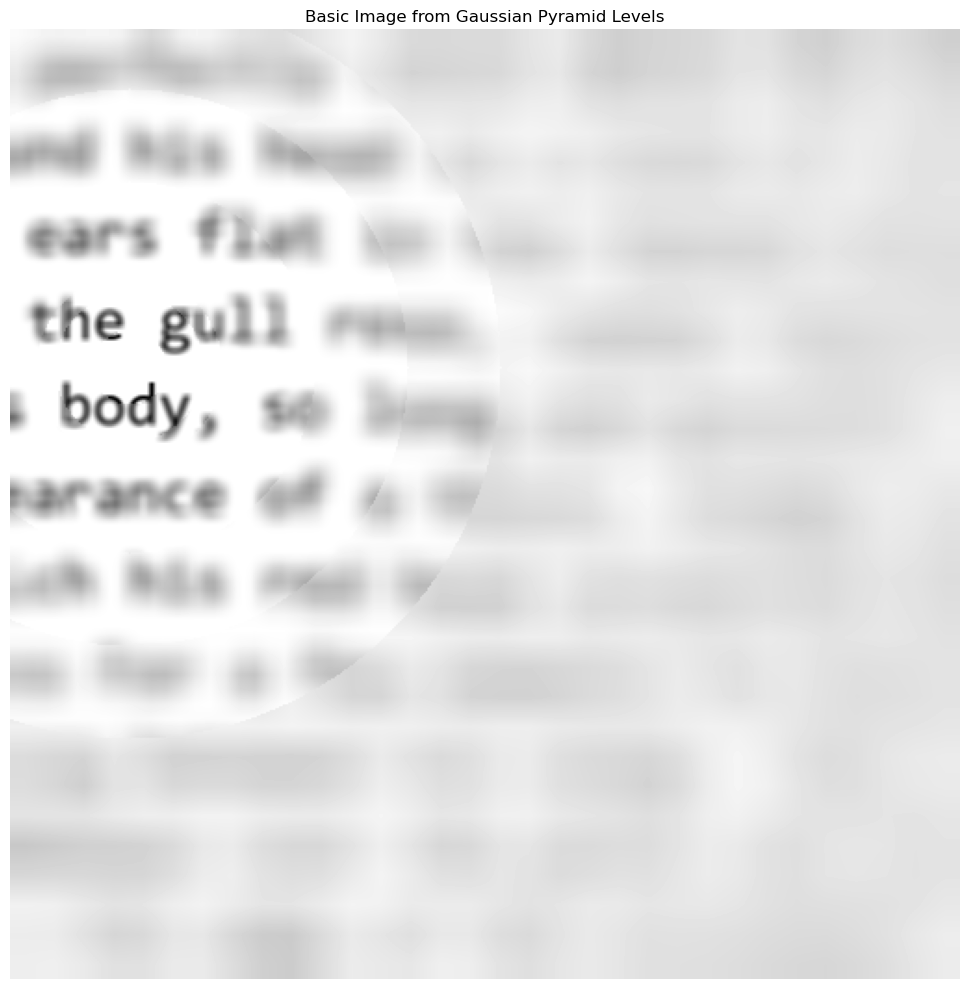

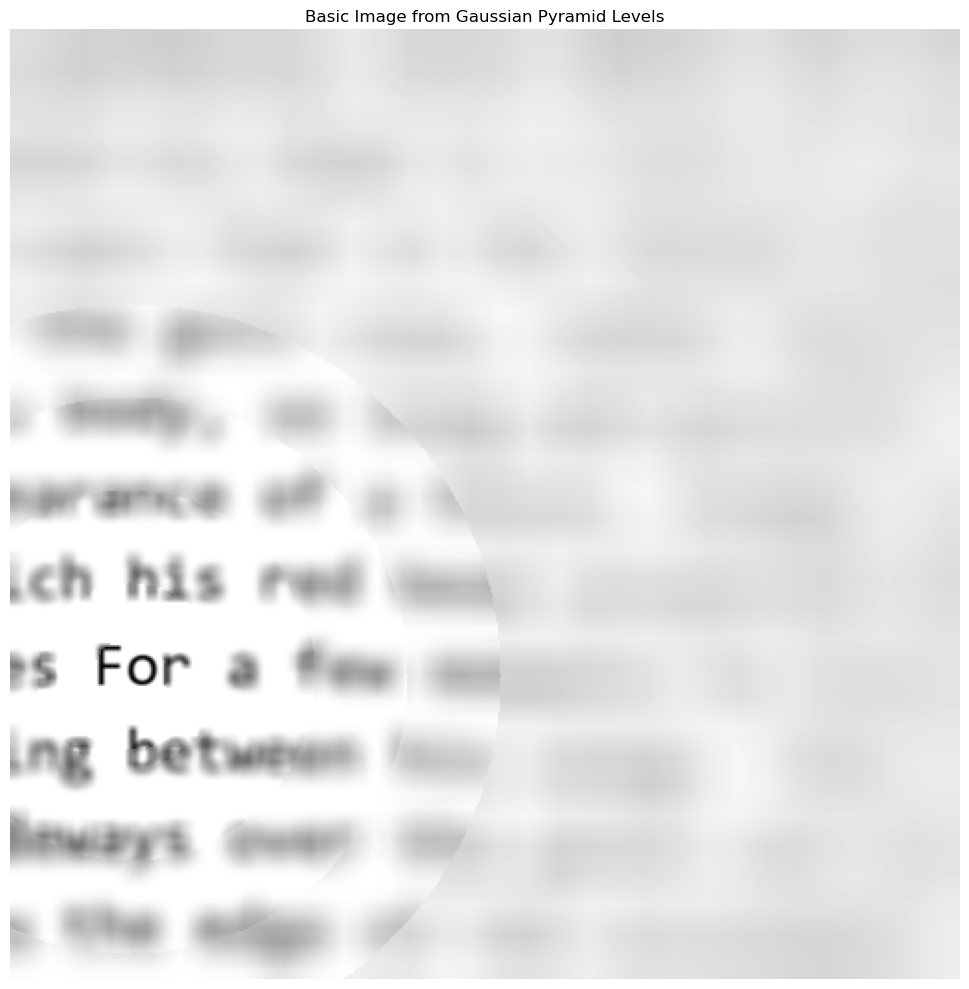

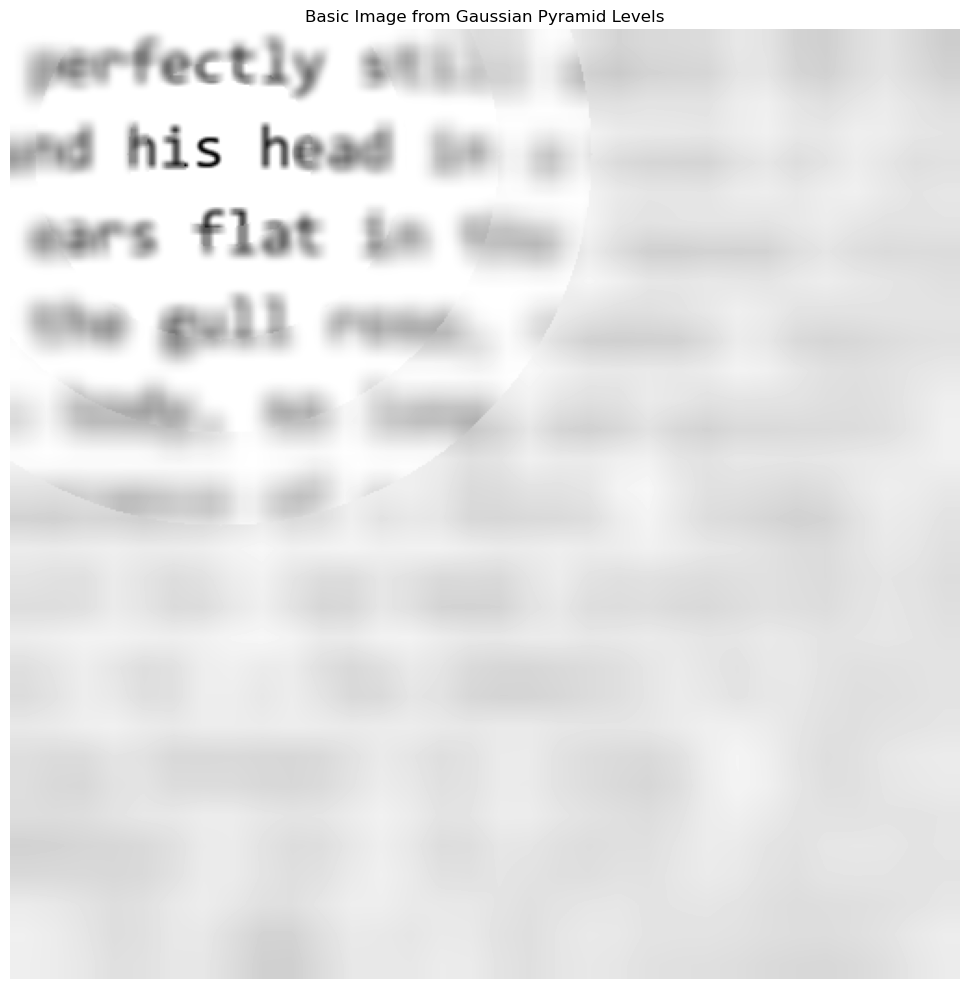

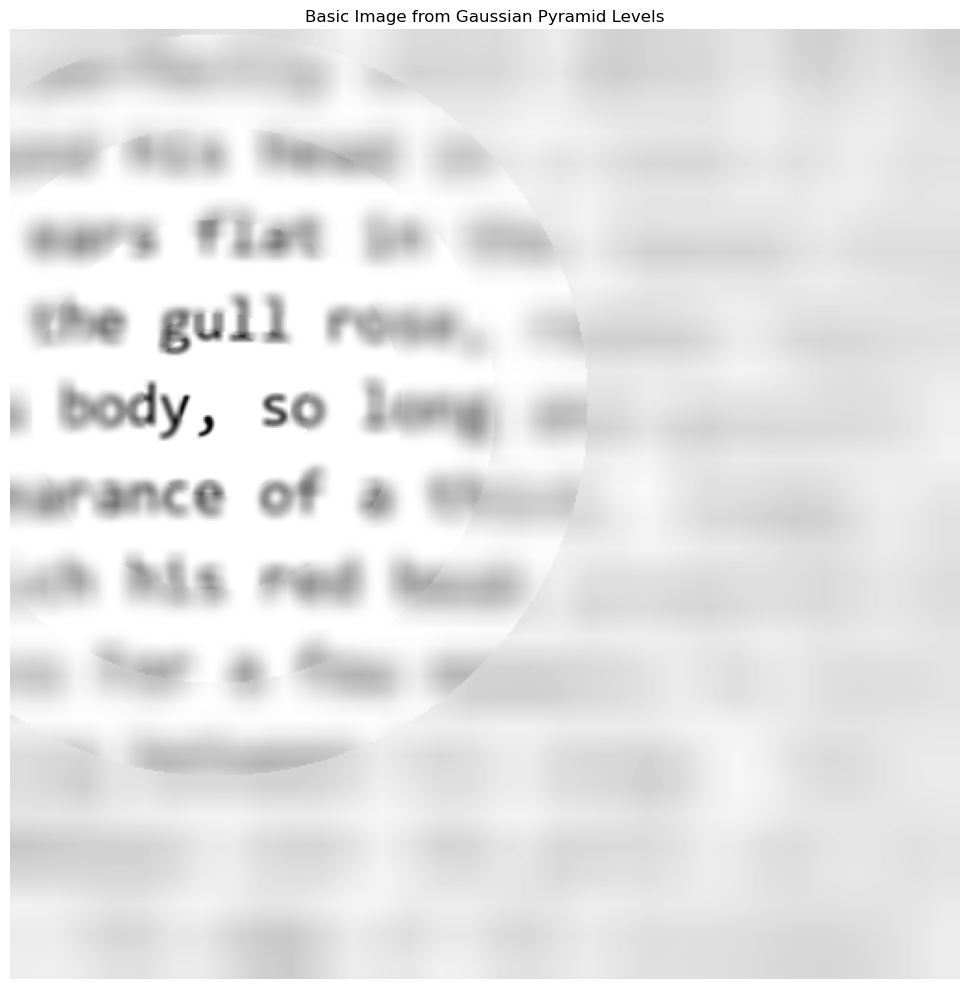

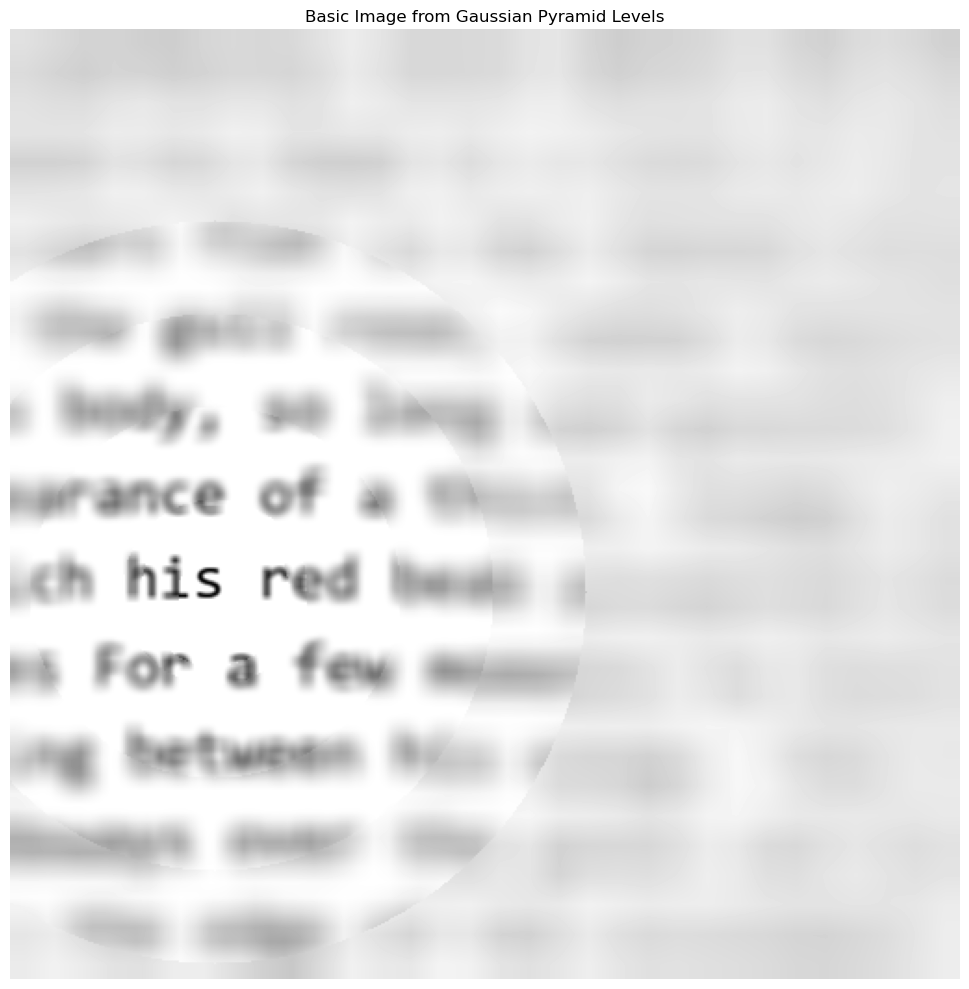

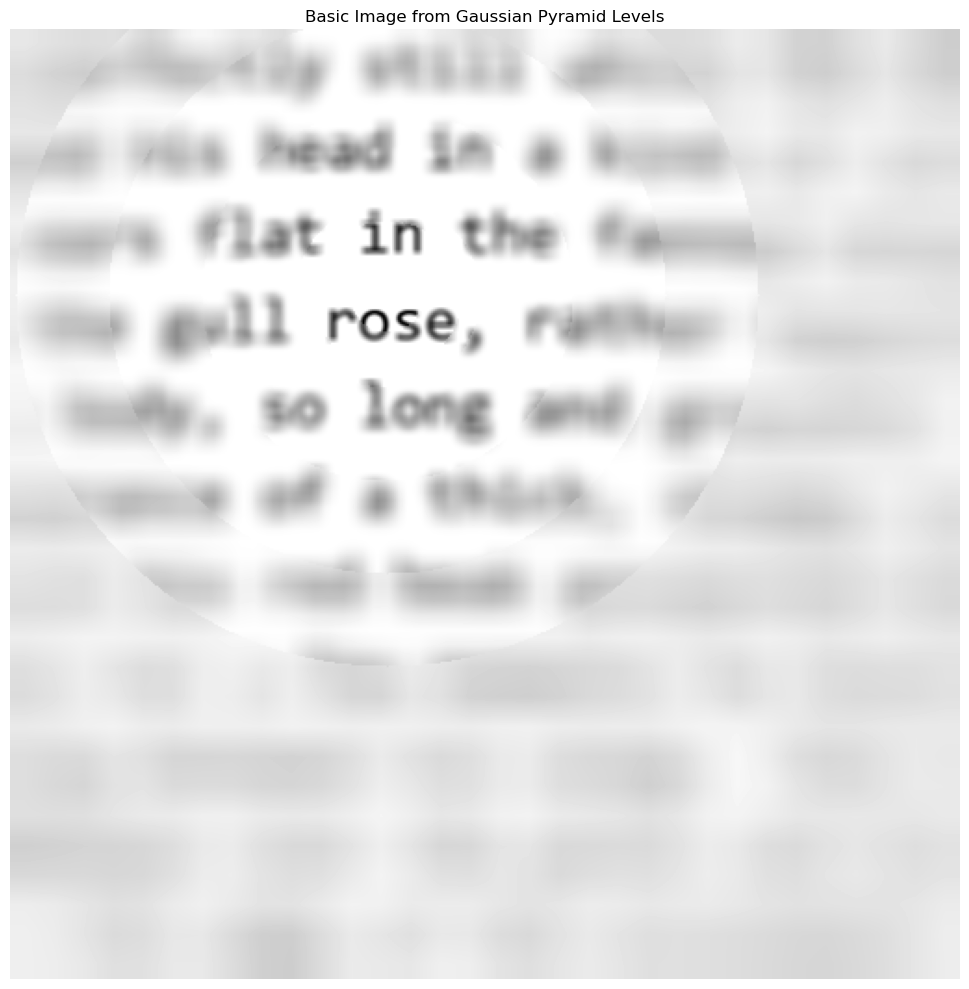

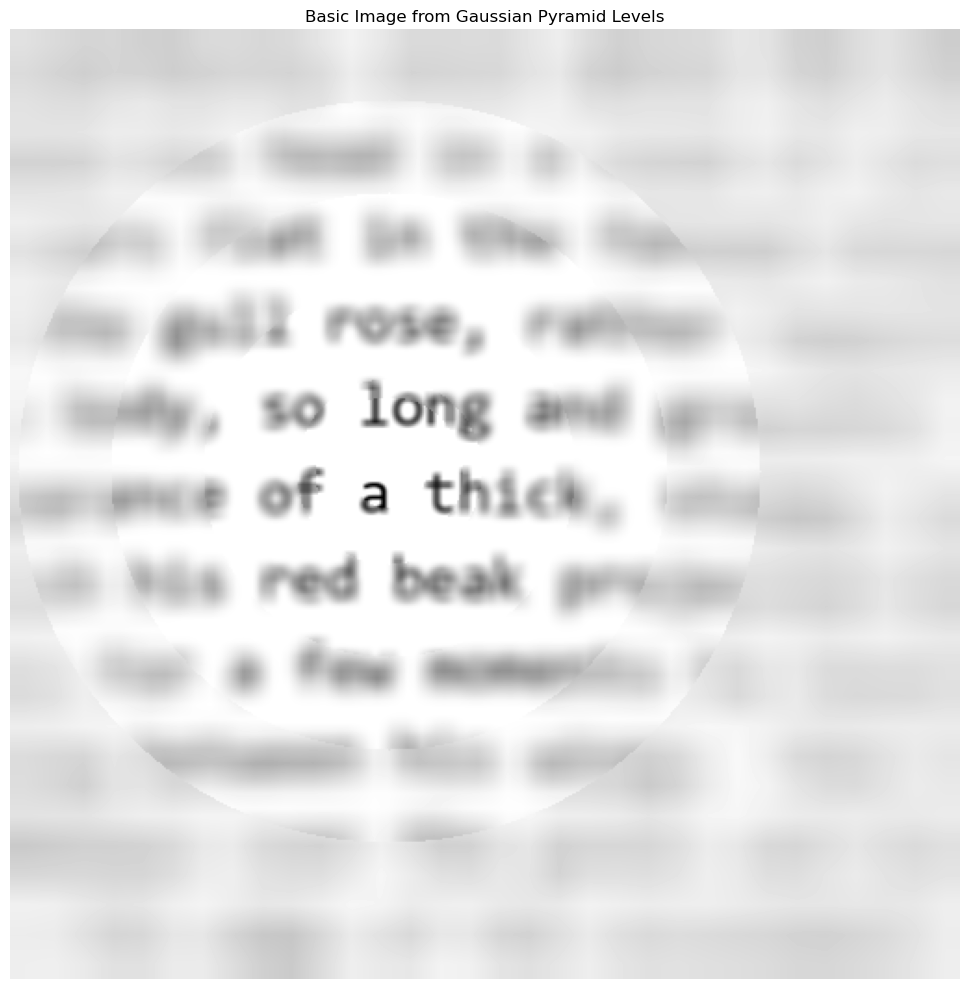

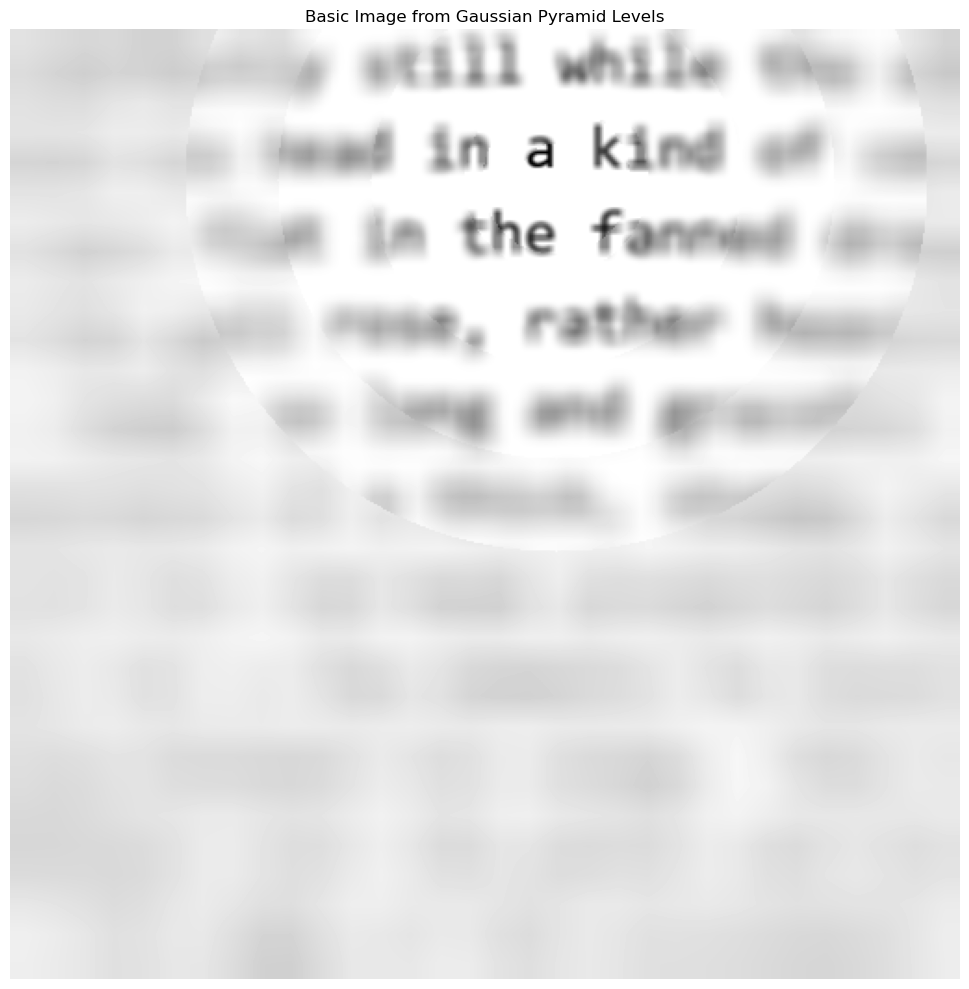

In [31]:
%run src/foveation_utils.py
for fixation_point in centers:
	distances = np.sqrt((x - fixation_point[0]) ** 2 + (y - fixation_point[1]) ** 2)
	pyramid_levels = make_foveation_lookup_table(distances, thresholds)
	(mean_texture_tmp, variance_texture_tmp, skew_texture_tmp) = compute_base_moments(keehar_plaintext_rgb, fixation_point)
	gaussian_pyramids = compute_basemoments_gaussian_pyramids(mean_texture_tmp, variance_texture_tmp, skew_texture_tmp, num_levels)
	laplacian_pyramids = compute_basemoments_laplacian_pyramids(gaussian_pyramids)
	basic_image_from_gaussian_pyramid_levels = basic_render_from_pyramid_levels(pyramid_levels, gaussian_pyramids, width, height)

	fig, axes = plt.subplots(1, 1, figsize=(10, 10))
	
	# Display the basic image from Gaussian pyramid levels
	axes.imshow(basic_image_from_gaussian_pyramid_levels, cmap='gray', origin='upper')
	axes.set_title("Basic Image from Gaussian Pyramid Levels")
	axes.axis("off")

	plt.tight_layout()
	plt.show()



Now we can try accumulating frames of the gaussian pyramid's means based off the previous frames. This is still suboptimal, since it uses the Gaussian pyramid and not the Laplacian or a Steerable one.

In [ ]:
%run src/foveation_utils.py

# TODO: Modify on Thursday
for fixation_point in centers:
	distances = np.sqrt((x - fixation_point[0]) ** 2 + (y - fixation_point[1]) ** 2)
	pyramid_levels = make_foveation_lookup_table(distances, thresholds)
	(mean_texture_tmp, variance_texture_tmp, skew_texture_tmp) = compute_base_moments(keehar_plaintext_rgb, fixation_point)
	gaussian_pyramids = compute_basemoments_gaussian_pyramids(mean_texture_tmp, variance_texture_tmp, skew_texture_tmp, num_levels)
	laplacian_pyramids = compute_basemoments_laplacian_pyramids(gaussian_pyramids)
	basic_image_from_gaussian_pyramid_levels = basic_render_from_pyramid_levels(pyramid_levels, gaussian_pyramids, width, height)

	fig, axes = plt.subplots(1, 1, figsize=(10, 10))
	
	# Display the basic image from Gaussian pyramid levels
	axes.imshow(basic_image_from_gaussian_pyramid_levels, cmap='gray', origin='upper')
	axes.set_title("Basic Image from Gaussian Pyramid Levels")
	axes.axis("off")

	plt.tight_layout()
	plt.show()



KeyboardInterrupt: 

In [ ]:
# To do this temporally, probably want to think about a reservoir ? Importance sampling may not be necessary though